<a href="https://colab.research.google.com/github/csinnewcastle/DeepLearningDrugRepurpsing/blob/master/GNN_NedRex_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Access google drive to import the nodes and edges files, all files on google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#install sentence _transformers models for features encodeing

In [ ]:
pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 1.7 MB/s eta 0:00:00


In [ ]:
#use sentence transformers for text embedding for nodes and edges features
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
import pandas as pd
import torch
import csv

#Get the nodes files paths from google drive

disorder_path='/content/drive/MyDrive/KG/disorder.csv'
drug_path ='/content/drive/MyDrive/KG/drug.csv'
gene_path ='/content/drive/MyDrive/KG/gene.csv'
protein_path ='/content/drive/MyDrive/KG/protein.csv'
pathway_path='/content/drive/MyDrive/KG/pathway.csv'
phenotype_path='/content/drive/MyDrive/KG/phenotype.csv'
side_effect_path='/content/drive/MyDrive/KG/side_effect.csv'
tissue_path='/content/drive/MyDrive/KG/tissue.csv'
signature_path='/content/drive/MyDrive/KG/signature.csv'
go_path='/content/drive/MyDrive/KG/go.csv'
#variant_path='/content/drive/MyDrive/KG/variant.csv'
variant_path="genomic_variant.csv"
#Get the edgse files pathes from google drive

drug_has_indication_path='/content/drive/MyDrive/KG/drug_has_indication.csv'
gene_associated_with_disorder_path='/content/drive/MyDrive/KG/gene_associated_with_disorder.csv'
drug_has_target_path='/content/drive/MyDrive/KG/drug_has_target.csv'
drug_has_side_effect_path='/content/drive/MyDrive/KG/drug_has_side_effect.csv'
protein_encoded_by_gene_path='/content/drive/MyDrive/KG/protein_encoded_by_gene.csv'
disorder_is_subtype_of_disorder_path='/content/drive/MyDrive/KG/disorder_is_subtype_of_disorder.csv'
disorder_has_phenotype_path='/content/drive/MyDrive/KG/disorder_has_phenotype.csv'
drug_has_contraindication_path='/content/drive/MyDrive/KG/drug_has_contraindication.csv'
molecule_similarity_molecule_path='/content/drive/MyDrive/KG/molecule_similarity_molecule.csv'
protein_interacts_with_protein_path="protein_interacts_with_protein.csv"
protein_encodedby_gene_path="/content/drive/MyDrive/KG/protein_encoded_by_gene.csv"
protein_has_go_annotation_path="/content/drive/MyDrive/KG/protein_has_go_annotation.csv"
go_is_subtype_of_go_path="/content/drive/MyDrive/KG/go_is_subtype_of_go.csv"
protein_has_signature_path="/content/drive/MyDrive/KG/protein_has_signature.csv"
protein_in_pathway_path="/content/drive/MyDrive/KG/protein_in_pathway.csv"
side_effect_same_as_phenotype_path='/content/drive/MyDrive/KG/side_effect_same_as_phenotype.csv'
gene_expressed_in_tissue_path='/content/drive/MyDrive/KG/gene_expressed_in_tissue.csv'
protein_expressed_in_tissue_path='/content/drive/MyDrive/KG/protein_expressed_in_tissue.csv'
#variant_affects_gene_path='/content/drive/MyDrive/KG/variant_affects_gene.csv'
#variant_associated_with_disorder_path='/content/drive/MyDrive/KG/variant_associated_with_disorder.csv'
variant_associated_with_disorder_path = 'variant_associated_with_disorder.csv'
PFIN_path='PFINn.csv'
RepoDB_path='RepoDBv2.csv'
variant_affects_gene_path="variant_affects_gene.csv"
#Parsing a node file by passing file's path and use sentence transformer to features encoder

def load_node_csv(path, index_col,sep="\t", engine=None, encoding=None, quoting=3, encoders=None, **kwargs):
    df = pd.read_csv(path, index_col=index_col, **kwargs)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    #print(mapping)
    x = None

    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]

        x = torch.cat(xs, dim=-1)
    #print(x.size())
    return x.to(device), mapping

#Using sentence transformer model all-MiniLM-L6-v2 for featues embeddings

class SequenceEncoder(object):
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)

    @torch.no_grad()
    def __call__(self, df):
        x = self.model.encode(df.values, show_progress_bar=True,
                              convert_to_tensor=True, device=self.device)
        #print(x.size())
        return x.to(device)


# We may also need one hot embedding when a feature is present 1 and 0 when it is absent

class featuresEncoder(object):
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        features = set(f for col in df.values for f in col.split(self.sep))
        mapping = {feature: i for i, feature in enumerate(features)}
        print(features)
        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for feature in col.split(self.sep):
                x[i, mapping[feature]] = 1
        #print(x.size())
        return x.to(device)


# We use IdentityEncoder to features with double, or float types

class IdentityEncoder(object):
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(df.values).view(-1, 1).to(self.dtype).to(device)

#read an edge file by passing a file path

def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping,delimiter="\t", engine='python', encoding='utf-8', quoting=3
                  ,error_bad_lines=False, encoders=None, **kwargs):
    df = pd.read_csv(path, **kwargs)

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)
        edge_attr.to(dtype=torch.long)

    return edge_index, edge_attr


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import torch
from torch import Tensor
print(torch.__version__)

2.1.0+cu121


In [ ]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 67.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 44.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.3 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-60tm0d22
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-60tm0d22
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 3a56d4bfd50f16515138be73b748fa586747c3ef
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-any.whl

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torch_geometric.data import HeteroData
data = HeteroData()

In [ ]:
#read drug nodes from drug file and features using squenceencoder
#note: features selection depens on many factors:
# is the feature meaningfull, fore example 'dataSources' does not give a meaningful description for a node, it just tell you that this node comes from this data source!
# some features give very good description for the nodes but beacuse these feartures are missing for solme nodes, so we ignore these types of features,
# for example, 'description' is very good feature for drug, but because it is missing for some nodes, we ignor them
#return two values: drug_x:torch tensor stores nodes;features matrix, drug_mapping: Dict maps drug IDs to drug Index

drug_x, drug_mapping = load_node_csv(drug_path, index_col='primaryDomainId:ID', engine='python',encoding='utf-8', quoting=3, encoders={
        'displayName:string':SequenceEncoder(),
        #':LABEL':SequenceEncoder(),
        #'drugGroups:string[]':featuresEncoder(),
        #'description:string':SequenceEncoder(),
         #'sequence:string[]':SequenceEncoder(),
         #'indication:string':SequenceEncoder(),
         #'domainIds:string[]':featuresEncoder(),
         #'drugCategories:string[]':featuresEncoder(),
         #'dataSources:string[]': featuresEncoder()


    })

Batches:   0%|          | 0/448 [00:00<?, ?it/s]

In [ ]:
#read disorder nodes from disorder file and features using squenceencoder
#return two values: disorder_x:torch tensor stores disorders features matrix,disorder_mapping: Dict maps disorder IDs to disorder Index
disorder_x, disorder_mapping = load_node_csv(
    disorder_path, index_col='primaryDomainId:ID',engine='python',encoding='utf-8', quoting=3, encoders={
         'displayName:string':SequenceEncoder(),
          #'synonyms:string[]':SequenceEncoder(),
          #':LABEL':SequenceEncoder(),
          #'dataSources:string[]':SequenceEncoder()


    })

Batches:   0%|          | 0/700 [00:00<?, ?it/s]

In [ ]:
#read gene nodes from gene file and features using squenceencoder
# features:'chromosome', 'description', 'geneType'
gene_x, gene_mapping = load_node_csv(gene_path, index_col='primaryDomainId:ID',engine='python',encoding='utf-8', quoting=3, encoders={
         #'approvedSymbol:string':SequenceEncoder(),
         #'dataSources:string[]':SequenceEncoder(),
          'chromosome:string':SequenceEncoder(),
         'description:string':SequenceEncoder(),
         'geneType:string':SequenceEncoder(),
         #'mapLocation:string':SequenceEncoder(),
         'displayName:string':SequenceEncoder(),
         #'synonyms:string[]':SequenceEncoder(),
         #':LABEL':SequenceEncoder(),
         #'dataSources:string[]':SequenceEncoder(),


    })

Batches:   0%|          | 0/2547 [00:00<?, ?it/s]

Batches:   0%|          | 0/2547 [00:00<?, ?it/s]

Batches:   0%|          | 0/2547 [00:00<?, ?it/s]

Batches:   0%|          | 0/2547 [00:00<?, ?it/s]

In [ ]:
#read Protein nodes from Protein file and features using squenceencoder
# features:'Name', 'sequence'
Protein_x, protein_mapping = load_node_csv(
    protein_path, index_col='primaryDomainId:ID',engine='python',encoding='utf-8', quoting=3, encoders={
         #'dataSources:string[]':SequenceEncoder(),
         'displayName:string':SequenceEncoder(),
         #'geneName:string':SequenceEncoder(),
         #'synonyms:string[]':SequenceEncoder(),
          #':LABEL':SequenceEncoder(),
           'sequence:string':SequenceEncoder(),
          #'taxid:int':IdentityEncoder(),
          #'dataSources:string[]':SequenceEncoder(),


    },)

Batches:   0%|          | 0/6406 [00:00<?, ?it/s]

Batches:   0%|          | 0/6406 [00:00<?, ?it/s]

In [ ]:
#read phenotype nodes from phenotype file and features using squenceencoder
phenotype_x, phenotype_mapping = load_node_csv(
    phenotype_path, index_col='primaryDomainId:ID',engine='python',encoding='utf-8', quoting=3, encoders={
         'displayName:string':SequenceEncoder(),
          #':LABEL':SequenceEncoder(),
          #'dataSources:string[]':SequenceEncoder(),
          #'domainIds:string[]':featuresEncoder(),

    },)

Batches:   0%|          | 0/520 [00:00<?, ?it/s]

In [ ]:
#read pathway nodes from pathway path file and features using squenceencoder
pathway_x, pathway_mapping = load_node_csv(
    pathway_path, index_col='primaryDomainId:ID',engine='python',encoding='utf-8', quoting=3, encoders={
         #'dataSources:string[]':SequenceEncoder(),
         'displayName:string':SequenceEncoder(),
          #':LABEL':SequenceEncoder(),
          #'taxid:int':IdentityEncoder(),
          #'dataSources:string[]':SequenceEncoder(),
          #'domainIds:string[]':featuresEncoder(),
          #'species:string':SequenceEncoder(),

    },)

Batches:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
#read side_effect nodes from side_effect file and features using squenceencoder
side_effect_x, side_effect_mapping = load_node_csv(
    side_effect_path, index_col='primaryDomainId:ID',engine='python',encoding='utf-8', quoting=3, encoders={
         'displayName:string':SequenceEncoder(),
          #':LABEL':SequenceEncoder(),
          #'dataSources:string[]':SequenceEncoder(),
          #'domainIds:string[]':featuresEncoder(),

    },)

Batches:   0%|          | 0/472 [00:00<?, ?it/s]

In [ ]:
#read tissue nodes from tissue file and features using squenceencoder
tissue_x, tissue_mapping = load_node_csv(
    tissue_path, index_col='primaryDomainId:ID',engine='python',encoding='utf-8', quoting=3, encoders={
         'displayName:string':SequenceEncoder(),
          #':LABEL':SequenceEncoder(),
          #'dataSources:string[]':SequenceEncoder(),
         # 'domainIds:string[]':featuresEncoder(),

    },)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#read signature nodes from signature file and features using squenceencoder
signature_x, signature_mapping = load_node_csv(
    signature_path, index_col='primaryDomainId:ID',engine='python',encoding='utf-8', quoting=3, encoders={
         #'displayName:string':SequenceEncoder(),
          ':LABEL':SequenceEncoder(),
          #'dataSources:string[]':SequenceEncoder(),
          #'domainIds:string[]':featuresEncoder(),

    },)

Batches:   0%|          | 0/1319 [00:00<?, ?it/s]

In [ ]:
variant_x,variant_mapping = load_node_csv(
    variant_path, index_col='primaryDomainId:ID',engine='python',encoding='utf-8', quoting=3, encoders={
          #'displayName:string':SequenceEncoder(),
          ':LABEL':SequenceEncoder(),
         # 'dataSources:string[]':SequenceEncoder(),
          #'domainIds:string[]':featuresEncoder(),
          #'description:string':SequenceEncoder(),

    },)

<ipython-input-4-3d09694d8774>:51: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, index_col=index_col, **kwargs)


Batches:   0%|          | 0/46099 [00:00<?, ?it/s]

In [ ]:
print(len(variant_mapping))

1475162


In [ ]:
#read gene nodes from gene file and features using squenceencoder
# features:'description', 'Name'
go_x, go_mapping = load_node_csv(
    go_path, index_col='primaryDomainId:ID',engine='python',encoding='utf-8', quoting=3, encoders={
          'displayName:string':SequenceEncoder(),
          #':LABEL':SequenceEncoder(),
         # 'dataSources:string[]':SequenceEncoder(),
          #'domainIds:string[]':featuresEncoder(),
          'description:string':SequenceEncoder(),

    },)

Batches:   0%|          | 0/1362 [00:00<?, ?it/s]

Batches:   0%|          | 0/1362 [00:00<?, ?it/s]

In [ ]:

#now we read edge files
# read drug_has_indication edge
#return two values: drug_has_indication_index:edge Index, and drug_has_indication_attributes: torch represent edges features
drug_has_indication_index, drug_has_indication_attributes = load_edge_csv(
    drug_has_indication_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=drug_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=disorder_mapping,
    #encoders={':TYPE':SequenceEncoder()


    # },
)

In [ ]:
print(drug_has_indication_index)

tensor([[10889, 13614, 12794,  ...,  9645,  8225,  8225],
        [21780, 20294, 13458,  ..., 16097,  7922,  8234]])


In [ ]:
drug_has_contraindication_index, drug_has_contraindication_attributes = load_edge_csv(
    drug_has_contraindication_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=drug_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=disorder_mapping,
    #encoders={':TYPE':SequenceEncoder() #},
)

In [ ]:
drug_has_side_effect_index, drug_has_side_effect_attributes = load_edge_csv(
    drug_has_side_effect_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=drug_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=side_effect_mapping,
    #encoders={#':TYPE':SequenceEncoder(),
             # 'maximum_frequency:double':IdentityEncoder(),
             # 'minimum_frequency:double':IdentityEncoder(),
             # },
)

In [ ]:
drug_has_target_index, drug_has_target_attributes = load_edge_csv(
    drug_has_target_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=drug_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=protein_mapping,
   #encoders={':TYPE':SequenceEncoder(),
              #'dataSources:string[]':featuresEncoder(),
              #},
              )

In [ ]:
molecule_similarity_molecule_index, molecule_similarity_molecule_attributes = load_edge_csv(
    molecule_similarity_molecule_path,
    src_index_col='memberOne:START_ID',
    src_mapping=drug_mapping,
    dst_index_col='memberTwo:END_ID',
    dst_mapping=drug_mapping,
   #encoders={#':TYPE':SequenceEncoder(),
               #'maccs:double':IdentityEncoder(),
               #'morgan_r1:double':IdentityEncoder(),
               #'morgan_r2:double':IdentityEncoder(),
               # 'morgan_r3:double':IdentityEncoder(),
               # 'morgan_r4:double':IdentityEncoder()
              #},
)

In [ ]:
protein_interacts_with_protein_index, protein_interacts_with_protein_attributes = load_edge_csv(
    protein_interacts_with_protein_path,
    src_index_col='memberOne:START_ID',
    src_mapping=protein_mapping,
    dst_index_col='memberTwo:END_ID',
    dst_mapping=protein_mapping,
   # encoders={':TYPE':SequenceEncoder(),
              #'evidenceTypes:string[]':featuresEncoder(),
             # 'methods:string[]':SequenceEncoder(),
             # },
)

In [ ]:
print(protein_interacts_with_protein_index.size())

torch.Size([2, 174864])


In [ ]:
protein_has_signature_index, protein_has_signature_attributes = load_edge_csv(
    protein_has_signature_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=protein_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=signature_mapping,
     #encoders={':TYPE':SequenceEncoder(),
               #'dataSources:string[]:':SequenceEncoder(),
             # },
)

In [ ]:
protein_encodedby_gene_index, protein_encodedby_gene_attributes = load_edge_csv(
    protein_encodedby_gene_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=protein_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=gene_mapping,
     #encoders={':TYPE':SequenceEncoder(),
               #'dataSources:string[]:':SequenceEncoder(),
             # },
)

In [ ]:
protein_has_go_annotations_index, protein_has_go_annotations_attributes = load_edge_csv(
    protein_has_go_annotation_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=protein_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=go_mapping,
    #encoders={#':TYPE':SequenceEncoder(),
             # 'qualifiers:string[]':SequenceEncoder(),
             # },
)

In [ ]:
protein_in_pathway_index, protein_in_pathway_attributes = load_edge_csv(
    protein_in_pathway_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=protein_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=pathway_mapping,
   #encoders={':TYPE':SequenceEncoder(),
              #},
)

In [ ]:
protein_expressed_in_tissue_index, protein_expressed_intissue_attributes = load_edge_csv(
    protein_expressed_in_tissue_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=protein_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=tissue_mapping,
   # encoders={#':TYPE':SequenceEncoder(),
             # 'level:string':SequenceEncoder()
              #},
)

In [ ]:
gene_expressed_in_tissue_index, gene_expressed_intissue_attributes = load_edge_csv(
    gene_expressed_in_tissue_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=gene_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=tissue_mapping,
    #encoders={#':TYPE':SequenceEncoder(),
             # 'TPM:double':IdentityEncoder(),
             # 'nTPM:double':IdentityEncoder(),
             # },
)

In [ ]:
go_is_subtype_of_go_index, go_is_subtype_of_go_attributes = load_edge_csv(
    go_is_subtype_of_go_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=go_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=go_mapping,
    #encoders={':TYPE':SequenceEncoder(),
              #},
)

In [ ]:
protein_encoded_by_gene_index, protein_encoded_by_gene_attributes = load_edge_csv(
    protein_encoded_by_gene_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=protein_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=gene_mapping,
    #encoders={':TYPE':SequenceEncoder(),
              #'dataSources:string[]':featuresEncoder(),
             # },
              )

In [ ]:
side_effect_same_as_phenotype_index, side_effect_same_as_phenotype_attributes = load_edge_csv(
    side_effect_same_as_phenotype_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=side_effect_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=phenotype_mapping,
   # encoders={':TYPE':SequenceEncoder(),
              #'dataSources:string[]':featuresEncoder(),
             # },
              )

In [ ]:
gene_associated_with_disoreder_index, gene_associated_with_disorder_attributes = load_edge_csv(
    gene_associated_with_disorder_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=gene_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=disorder_mapping,
     encoders={':TYPE':SequenceEncoder(),
              #'dataSources:string[]':featuresEncoder(),
                'score:double':IdentityEncoder(),
              },
              )

Batches:   0%|          | 0/946 [00:00<?, ?it/s]

In [ ]:
disorder_is_subtype_of_disorder_index, Disorder_Is_Subtype_Of_Disorder_attributes = load_edge_csv(
    disorder_is_subtype_of_disorder_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=disorder_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=disorder_mapping,
    #encoders={':TYPE':SequenceEncoder() },
)

In [ ]:
disorder_has_phenotype_index, disorder_has_phenotype_attributes = load_edge_csv(
    disorder_has_phenotype_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=disorder_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=phenotype_mapping,
   # encoders={':TYPE':SequenceEncoder() },
)

In [ ]:
variant_associated_with_disorder_index, variant_affects_gene_attributes = load_edge_csv(
    variant_associated_with_disorder_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=variant_mapping ,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=disorder_mapping,
    encoders={'accession:string':SequenceEncoder(),
              #':TYPE':SequenceEncoder(),
               #'effects:string[]':SequenceEncoder(),
              # 'reviewStatus:string':SequenceEncoder(),
             # 'dataSources:string[]':featuresEncoder(),
              },)

Batches:   0%|          | 0/34504 [00:00<?, ?it/s]

In [ ]:
variant_affects_gene_index, variant_affects_gene_attributes = load_edge_csv(
    variant_affects_gene_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=variant_mapping ,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=gene_mapping,
    encoders={':TYPE':SequenceEncoder(),
              'dataSources:string[]':featuresEncoder(),
              },)

In [ ]:
print(variant_associated_with_disorder_index.size())

torch.Size([2, 1104119])


In [ ]:
#read Disease-gene association from the PFIN
#NedRex database use MondoID for diseases terms, so i had to map umls id in my pfins to mondoID
#using Mondo_Ontology_equavilant
gene_associated_with_disoreder_PFIN_index, gene_associated_with_disorder_attributes_PFIN = load_edge_csv(
    PFIN_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=gene_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=disorder_mapping,
     encoders={#':TYPE':SequenceEncoder(),
              #'dataSources:string[]':featuresEncoder(),
                'score:double':IdentityEncoder(),
              },
              )

In [ ]:
#we read edge file of Drug-disorder from RepoDB standard drug repositioning database
#return two values: drug_has_indication_index:edge Index, and drug_has_indication_attributes: torch represent edges features
#remove drug-disease indication that already in NedRex graph
#remove drug-disease indication where drugs, disease nodes are not in NedRex garph
drug_has_indication_index_RepoDB, drug_has_indication_attributes_RepoDB = load_edge_csv(RepoDB_path,
    src_index_col='sourceDomainId:START_ID',
    src_mapping=drug_mapping,
    dst_index_col='targetDomainId:END_ID',
    dst_mapping=disorder_mapping,
    #encoders={':TYPE':SequenceEncoder()


    # },
)

In [ ]:
# first build the simple graph:drug-disease-gene-protein without node features

from torch_geometric.data import HeteroData
data = HeteroData()

# Save node indices:

data["disorder"].node_id = torch.arange(len(disorder_mapping))
data["drug"].node_id = torch.arange(len(drug_mapping))
data["protein"].node_id = torch.arange(len(protein_mapping))
data["gene"].node_id = torch.arange(len(gene_mapping))




#save node features

data['drug'].x= torch.ones_like(drug_x)#.to(dtype=torch.double)
data['disorder'].x = torch.ones_like(disorder_x)#.to(dtype=torch.double)
data['gene'].x= torch.ones_like(gene_x)#.to(dtype=torch.double)
data['protein'].x = torch.ones_like(Protein_x)#.to(dtype=torch.double)

#save edge indices

data['protein', 'EncodedBy', 'gene'].edge_index = protein_encoded_by_gene_index
data['gene', 'AWith', 'disorder'].edge_index = gene_associated_with_disoreder_index
data['drug', 'HasTarget', 'protein'].edge_index = drug_has_target_index
data['drug', 'HasIndication', 'disorder'].edge_index = drug_has_indication_index.to(dtype=torch.long)
data['protein', 'interact_with', 'protein'].edge_index=protein_interacts_with_protein_index

In [ ]:
# then build the simple graph:drug-disease-gene-protein with nodes features
#now we create hetergraph containing different and diverse types of nodes and edges
from torch_geometric.data import HeteroData
data = HeteroData()

# Save node indices:

data["disorder"].node_id = torch.arange(len(disorder_mapping))
data["drug"].node_id = torch.arange(len(drug_mapping))
data["protein"].node_id = torch.arange(len(protein_mapping))
data["gene"].node_id = torch.arange(len(gene_mapping))


#save node features

data['drug'].x= drug_x#.to(dtype=torch.double)
data['disorder'].x = disorder_x#.to(dtype=torch.double)
data['gene'].x= gene_x#.to(dtype=torch.double)
data['protein'].x = Protein_x#.to(dtype=torch.double)

#save edge indices

data['protein', 'EncodedBy', 'gene'].edge_index = protein_encoded_by_gene_index
data['gene', 'AWith', 'disorder'].edge_index = gene_associated_with_disoreder_index
data['drug', 'HasTarget', 'protein'].edge_index = drug_has_target_index
data['drug', 'HasIndication', 'disorder'].edge_index = drug_has_indication_index.to(dtype=torch.long)
data['protein', 'interact_with', 'protein'].edge_index=protein_interacts_with_protein_index

In [ ]:
data['drug', 'HasIndication', 'disorder'].edge_index = drug_has_indication_index_RepoDB

In [ ]:
data

In [ ]:
#Creating complex hetergenous graph without node features
#now we create the complex hetergraph containing different and diverse types of nodes and edges
from torch_geometric.data import HeteroData
data = HeteroData()

# Save node indices:

data["disorder"].node_id = torch.arange(len(disorder_mapping))
data["drug"].node_id = torch.arange(len(drug_mapping))
data["protein"].node_id = torch.arange(len(protein_mapping))
data["gene"].node_id = torch.arange(len(gene_mapping))
data["pathway"].node_id = torch.arange(len(pathway_mapping))
data["phenotype"].node_id = torch.arange(len(phenotype_mapping))
data["side_effect"].node_id = torch.arange(len(side_effect_mapping))
data["signature"].node_id = torch.arange(len(signature_mapping))
data["go"].node_id = torch.arange(len(go_mapping))
data["tissue"].node_id = torch.arange(len(gene_mapping))

#save node features
data['drug'].x= torch.ones_like(drug_x)#.to(dtype=torch.double)
data['disorder'].x = torch.ones_like(disorder_x)#.to(dtype=torch.double)
data['gene'].x= torch.ones_like(gene_x)#.to(dtype=torch.double)
data['protein'].x = torch.ones_like(Protein_x)#.to(dtype=torch.double)
data['pathway'].x= torch.ones_like(pathway_x)#.to(dtype=torch.double)
data['phenotype'].x= torch.ones_like(phenotype_x)#.to(dtype=torch.double)
data['side_effect'].x= torch.ones_like(side_effect_x)#.to(dtype=torch.double)
data['go'].x= torch.ones_like(go_x)#.to(dtype=torch.double)
data['signature'].x= torch.ones_like(signature_x)#.to(dtype=torch.double)
data['tissue'].x= torch.ones_like(tissue_x)#.to(dtype=torch.double)
#save edge indices

data['gene', 'AWith', 'disorder'].edge_index = gene_associated_with_disoreder_index
data['drug', 'HasTarget', 'protein'].edge_index = drug_has_target_index
data['drug', 'HasIndication', 'disorder'].edge_index = drug_has_indication_index.to(dtype=torch.long)
data['drug', 'drug_has_side_effect', 'side_effect'].edge_index = drug_has_side_effect_index
data['disorder', 'disorder_is_subtype_of_disorder', 'disorder'].edge_index=disorder_is_subtype_of_disorder_index
data['disorder', 'disorder_has_phenotype', 'phenotype'].edge_index=disorder_has_phenotype_index
data['drug', 'drug_has_contraindication', 'disorder'].edge_index=drug_has_contraindication_index
data['drug','molecule_similarity_molecule_index','drug'].edge_index=molecule_similarity_molecule_index
data['protein', 'protein_has_go_annotation', 'go'].edge_index=protein_has_go_annotations_index
data['go', 'go_is_subtype_of_go', 'go'].edge_index=go_is_subtype_of_go_index
data['protein', 'protein_in_pathway', 'pathway'].edge_index=protein_in_pathway_index
data['gene', 'gene_expressed_in_tissue', 'tissue'].edge_index=gene_expressed_in_tissue_index
data['protein', 'protein_expressed_in_tissue', 'tissue'].edge_index=protein_expressed_in_tissue_index
data['protein', 'interact_with', 'protein'].edge_index=protein_interacts_with_protein_index
data['protein','protein_has_signature', 'signature'].edge_index=protein_has_signature_index
data['protein', 'EncodedBy', 'gene'].edge_index = protein_encoded_by_gene_index

In [ ]:
data['drug'].x= torch.ones_like(drug_x)

In [ ]:
data['drug'].x

In [ ]:
#now we create the complex hetergraph containing different and diverse types of nodes and edges
# adding nodes features to the graph
from torch_geometric.data import HeteroData
data = HeteroData()

# Save node indices:

data["disorder"].node_id = torch.arange(len(disorder_mapping))
data["drug"].node_id = torch.arange(len(drug_mapping))
data["protein"].node_id = torch.arange(len(protein_mapping))
data["gene"].node_id = torch.arange(len(gene_mapping))
data["pathway"].node_id = torch.arange(len(pathway_mapping))
data["phenotype"].node_id = torch.arange(len(phenotype_mapping))
data["side_effect"].node_id = torch.arange(len(side_effect_mapping))
data["signature"].node_id = torch.arange(len(signature_mapping))
data["go"].node_id = torch.arange(len(go_mapping))
data["tissue"].node_id = torch.arange(len(gene_mapping))

#save node features

data['drug'].x= drug_x#.to(dtype=torch.double)
data['disorder'].x = disorder_x#.to(dtype=torch.double)
data['gene'].x= gene_x#.to(dtype=torch.double)
data['protein'].x = Protein_x#.to(dtype=torch.double)
data['pathway'].x= pathway_x#.to(dtype=torch.double)
data['phenotype'].x= phenotype_x#.to(dtype=torch.double)
data['side_effect'].x= side_effect_x#.to(dtype=torch.double)
data['go'].x= go_x#.to(dtype=torch.double)
data['signature'].x= signature_x#.to(dtype=torch.double)
data['tissue'].x= tissue_x#.to(dtype=torch.double)

#save edge indices

data['gene', 'AWith', 'disorder'].edge_index = gene_associated_with_disoreder_index
data['drug', 'HasTarget', 'protein'].edge_index = drug_has_target_index
data['drug', 'HasIndication', 'disorder'].edge_index = drug_has_indication_index.to(dtype=torch.long)
data['drug', 'drug_has_side_effect', 'side_effect'].edge_index = drug_has_side_effect_index
data['disorder', 'disorder_is_subtype_of_disorder', 'disorder'].edge_index=disorder_is_subtype_of_disorder_index
data['disorder', 'disorder_has_phenotype', 'phenotype'].edge_index=disorder_has_phenotype_index
data['drug', 'drug_has_contraindication', 'disorder'].edge_index=drug_has_contraindication_index
data['drug','molecule_similarity_molecule_index','drug'].edge_index=molecule_similarity_molecule_index
data['protein', 'protein_has_go_annotation', 'go'].edge_index=protein_has_go_annotations_index
data['go', 'go_is_subtype_of_go', 'go'].edge_index=go_is_subtype_of_go_index
data['protein', 'protein_in_pathway', 'pathway'].edge_index=protein_in_pathway_index
data['gene', 'gene_expressed_in_tissue', 'tissue'].edge_index=gene_expressed_in_tissue_index
data['protein', 'protein_expressed_in_tissue', 'tissue'].edge_index=protein_expressed_in_tissue_index
data['protein', 'interact_with', 'protein'].edge_index=protein_interacts_with_protein_index
data['protein','protein_has_signature', 'signature'].edge_index=protein_has_signature_index
data['protein', 'EncodedBy', 'gene'].edge_index = protein_encoded_by_gene_index
#save edges features
data['protein', 'EncodedBy', 'gene'].edge_attr = protein_encoded_by_gene_attributes
data['gene', 'AWith', 'disorder'].edge_attr =gene_associated_with_disorder_attributes
data['drug', 'HasTarget', 'protein'].edge_attr=drug_has_target_attributes
data['drug', 'HasIndication', 'disorder'].edge_attr = drug_has_indication_attributes
data['drug', 'drug_has_side_effect', 'side_effect'].edge_attr = drug_has_side_effect_attributes
data['disorder', 'disorder_is_subtype_of_disorder', 'disorder'].edge_attr= Disorder_Is_Subtype_Of_Disorder_attributes
data['disorder', 'disorder_has_phenotype', 'phenotype'].edge_attr= disorder_has_phenotype_attributes
data['drug', 'drug_has_contraindication', 'disorder'].edge_attr=drug_has_contraindication_attributes
data['drug','molecule_similarity_molecule_index','drug'].edge_attr=molecule_similarity_molecule_attributes
data['protein', 'protein_has_go_annotation', 'go'].edge_attr=protein_has_go_annotations_attributes
data['go', 'go_is_subtype_of_go', 'go'].edge_attr=go_is_subtype_of_go_attributes
data['protein', 'protein_in_pathway', 'pathway'].edge_attr=protein_in_pathway_attributes
data['gene', 'gene_expressed_in_tissue', 'tissue'].edge_attr=gene_expressed_intissue_attributes
data['protein', 'protein_expressed_in_tissue', 'tissue'].edge_attr=protein_expressed_intissue_attributes
data['protein', 'EncodedBy', 'gene'].edge_attr= protein_encoded_by_gene_attributes

In [ ]:
#After training and validation the orignal graph (NedRex_HBKG), replace DGAs edges
#in the graph with DGAs from the PFIN
data['gene', 'AWith', 'disorder'].edge_index = gene_associated_with_disoreder_PFIN_index


In [ ]:
data['drug', 'HasIndication', 'disorder'].edge_index = drug_has_indication_index_RepoDB

In [ ]:
data

In [ ]:
#convert the Hetrograph to undirect graph: reverse edges allowing message passing from/to both nodes source and target
#Using Pytorch Geometric transform
#in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T
from torch.nn import Linear
import torch.nn.functional as F
torch.cuda.is_available()
data = T.ToUndirected()(data)#undirected graph, by adding reverse edges for all edges in the graph
#data = T.AddSelfLoops()(data)
data.to(device)
#data = T.NormalizeFeatures()(data)
data


HeteroData(
  disorder={
    node_id=[22384],
    x=[22384, 384],
  },
  drug={
    node_id=[14315],
    x=[14315, 384],
  },
  protein={
    node_id=[204961],
    x=[204961, 768],
  },
  gene={
    node_id=[81491],
    x=[81491, 1536],
  },
  pathway={
    node_id=[2566],
    x=[2566, 384],
  },
  phenotype={
    node_id=[16614],
    x=[16614, 384],
  },
  side_effect={
    node_id=[15095],
    x=[15095, 384],
  },
  signature={
    node_id=[42199],
    x=[42199, 384],
  },
  go={
    node_id=[43558],
    x=[43558, 768],
  },
  tissue={
    node_id=[81491],
    x=[64, 384],
  },
  (gene, AWith, disorder)={
    edge_index=[2, 30252],
    edge_attr=[30252, 385],
  },
  (drug, HasTarget, protein)={ edge_index=[2, 26537] },
  (drug, HasIndication, disorder)={ edge_index=[2, 1250] },
  (drug, drug_has_side_effect, side_effect)={ edge_index=[2, 217739] },
  (disorder, disorder_is_subtype_of_disorder, disorder)={ edge_index=[2, 71024] },
  (disorder, disorder_has_phenotype, phenotype)={ edge

In [ ]:
#Split the edges to Training, testing, and validation data
#10% test, 10% validation, and 80% training
# NO edges leakage between test, validation, and training data
#using randomlinkSplit function from pytorch geometric transforms
# Apply the transformation to the dataset
#We are interested in "drug", "HasIndication", "disorder" and the reverse edge "disorder", "rev_HasIndication", "drug"
import torch_geometric.transforms as T
transform = T.RandomLinkSplit(
    num_val=0.0,
    num_test=0.99,
    is_undirected=True,
    disjoint_train_ratio=0.0,
    neg_sampling_ratio=0.0,
    add_negative_train_samples=False,
    edge_types=("drug", "HasIndication", "disorder"),
    rev_edge_types=("disorder", "rev_HasIndication", "drug"),
)
train_data, val_data, test_data = transform(data)
#return train_data, val_data. and test_data

In [ ]:
test_data

In [ ]:
pip install wandb

In [ ]:
#Spliting training, testing, validation graphs to mini subgraph using data loader
#LinkNeighborlader generate samples from the both end of the link : drug end and disorder end
# and choose seed nodes and samples edges to creat subgraph
#negative sampling generating during the mini_bach loader
#the rate of negative sampling to positive is 1 :balance data

from torch_geometric.loader import LinkNeighborLoader
def MiniBatchesLoader(data,data_edge_label_index, data_edge_label,batch_size):
    data_loader = LinkNeighborLoader(
            data=data,
            num_neighbors=[20, 15, 10],
            neg_sampling_ratio=1.0,
            edge_label_index=(("drug", "HasIndication", "disorder"), data_edge_label_index),
            edge_label=data_edge_label,
            batch_size=batch_size,
            shuffle=True,
)

    return data_loader

In [ ]:
train_data

In [ ]:
#The first model is SAGEConv which use node features only to generate nodes embeddings
#The Model based on Encoder and decoder: decoder is the doct product of drug and disorder vectors
#two layers of GNN: we use Conv layers which use nodes features only ignoring edge features
#we use SAGE model which sampling subset of node's neighbours
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels,dropout):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.batchnorm = nn.BatchNorm1d(hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)
        self.dropout = nn.Dropout(p=dp)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.batchnorm(x).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.batchnorm(x)

        return x
class EdgeDecoder(torch.nn.Module):
     def __init__(self, hidden_dim):
        super().__init__()
        self.lin1 = Linear(2 * hidden_dim, hidden_dim)
        self.lin2 = Linear(hidden_dim, 1)

     def forward(self, z_dict, edge_label_index):
         #row, col = edge_label_index
         #z = torch.cat([z_dict['drug'][row], z_dict['disorder'][col]], dim=-1)
         #edge_feat_drug = z_dict['drug'][row]
         x_drug=z_dict["drug"]
         x_disorder=z_dict["disorder"]
         edge_feat_drug = x_drug[edge_label_index[0]]
         edge_feat_disorder = x_disorder[edge_label_index[1]]
         #z_dict_ij = torch.cat([z_dict_ij, z_dict_ij], dim=-1)
         #return self.mlp(z_dict_ij)
         #edge_feat_disorder = z_dict['disorder'][col]


         #Apply dot-product to get a prediction per supervision edge:
         z=(edge_feat_drug * edge_feat_disorder).sum(dim=-1)
         #z= z_dict['drug'][row] * z_dict['disorder'][col].sum(dim=-1)"""
         #z= torch.sigmoid(z)
         #z = self.lin1(z).relu()
         #z = self.lin2(z)

         #z= z.view(-1)
         z= torch.sigmoid(z)
         #print(z)
         return z

class Model(torch.nn.Module):
    def __init__(self, hidden_channels, doupout):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels,dropout)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='mean')
        self.decoder = EdgeDecoder(hidden_channels)
        # binary cross entropy loss with logits
        #self.loss = torch.nn.BCEWithLogitsLoss()
    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [ ]:
#The second Model is GAT which use nodes and edges features to generate edge attention score to generate nodes embeddings
#The Model based on Encoder and decoder: decoder is the doct product of drug and disorder vectors
#two layers of GNN: we use Graph attention network which use nodes features as well as edge features
#we use GAT model which generate attention edge attention scores based on edge and node features
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, dropout):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.batchnorm = nn.BatchNorm1d(hidden_channels)
        self.conv2 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.dropout = nn.Dropout(p=dp)
        #self.lin2 = Linear(-1, hidden_channels )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        #x = self.batchnorm(x).relu()
        #x = self.dropout(x)
        x = self.conv2(x, edge_index)
        #x = self.batchnorm(x)
        return x
class EdgeDecoder(torch.nn.Module):
     def __init__(self, hidden_dim):
        super().__init__()
        self.lin1 = Linear(2 * hidden_dim, hidden_dim)
        self.lin2 = Linear(hidden_dim, 1)

     def forward(self, z_dict, edge_label_index):
         row, col = edge_label_index
         z = torch.cat([z_dict['drug'][row], z_dict['disorder'][col]], dim=-1)
         #edge_feat_drug = z_dict['drug'][row]
         #edge_feat_disorder = z_dict['disorder'][col]

         """x_drug=z_dict["drug"]
         x_disorder=z_dict["disorder"]
         edge_feat_drug = x_drug[edge_label_index[0]]
         edge_feat_disorder = x_disorder[edge_label_index[1]]
         z_dict_i = z_dict_i[edge_label_index[0]]
         z_dict_j = z_dict_j[edge_label_index[1]]
         z_dict_ij = torch.cat([z_dict_ij, z_dict_ij], dim=-1)
         return self.mlp(z_dict_ij)"""


         #Apply dot-product to get a prediction per supervision edge:
         #z=(edge_feat_drug * edge_feat_disorder).sum(dim=-1)
         #z= z_dict['drug'][row] * z_dict['disorder'][col].sum(dim=-1)
         #z= torch.sigmoid(z)
         z = self.lin1(z).relu()
         z = self.lin2(z)
         #z= torch.sigmoid(z)
         z= z.view(-1)
         z= torch.sigmoid(z)
         return z




class ModelGAT(torch.nn.Module):
    def __init__(self, hidden_channels, doupout):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, dropout)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='mean')
        self.decoder = EdgeDecoder(hidden_channels)
        # binary cross entropy loss with logits
        #self.loss = torch.nn.BCEWithLogitsLoss()
    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [ ]:
with torch.no_grad():  # Initialize lazy modules.
    out = Model(train_data.x_dict, train_data.edge_index_dict, train_data['drug', 'HasIndication', 'disorder'].edge_label_index)

In [ ]:
#Training SAGE Model
def Train(train_loader):
    total_Precision = total_auc_score=total_correct=total_loss = total_examples = 0
    preds = []
    ground_truths = []
    cumulative_correct = 0
    cumulative_total = 0
    model.train()
    for sampled_data in tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred=model(sampled_data.x_dict, sampled_data.edge_index_dict, sampled_data['drug', 'HasIndication', 'disorder'].edge_label_index)

        ground_truth = sampled_data["drug", "HasIndication", "disorder"].edge_label.to(float)

        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        # Compute batch accuracy
        batch_correct = sum((pred > 0.50)==ground_truth)  # Direct comparison without axis
        batch_total = len(ground_truth)

        preds.append(pred)
        ground_truths.append(ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()

        total_examples += pred.numel()
        # Store values for batch-wise averaging
        cumulative_correct += float(batch_correct)

    train_loss= total_loss / total_examples
    # Calculate overall accuracy
    train_accuracy = float(cumulative_correct) / total_examples
    Fpred = torch.cat(preds, dim=0).cpu().detach().numpy()
    Fground_truth = torch.cat(ground_truths, dim=0).cpu().detach().numpy()
    aucroc = roc_auc_score(Fground_truth, Fpred)

    # Assuming you have precision and recall values obtained from your predictions and true labels
    precision, recall, thresholds = precision_recall_curve(Fground_truth, Fpred)

   # Calculate AUCPR
    aucpr = auc(recall, precision)
    return train_loss, train_accuracy, aucpr, aucroc


In [ ]:
from scipy.stats import ttest_1samp
def calculate_t_statistic_and_p_value(observations, null_hypothesis_value=0.5):
    t_statistic, p_value = ttest_1samp(observations, null_hypothesis_value)
    return t_statistic, p_value


In [ ]:
#Validation and testing SAGE Model
def Test(data_loader):
  batch_auc_roc_score=total_correct=total_val_loss = total_examples= 0
  preds = []
  ground_truths = []
  cumulative_correct = 0
  cumulative_total = 0

  for sampled_data in tqdm(data_loader):
       with torch.no_grad():
         sampled_data.to(device)
         pred=model(sampled_data.x_dict, sampled_data.edge_index_dict, sampled_data["drug", "HasIndication", "disorder"].edge_label_index)

         ground_truth = sampled_data["drug", "HasIndication", "disorder"].edge_label.to(float)

         preds.append(pred)
         ground_truths.append(ground_truth)
         loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
         total_val_loss += float(loss) * pred.numel()
         total_examples += pred.numel()
          # Compute batch accuracy

         batch_correct = sum((pred>=0.50) == ground_truth)


          # Store values for batch-wise averaging
         cumulative_correct += float(batch_correct)

       # Compute average validation loss

  val_loss= total_val_loss / total_examples
   # Calculate overall accuracy
  val_accuracy = cumulative_correct / total_examples
  Fpred = torch.cat(preds, dim=0).cpu().detach().numpy()
  Fground_truth = torch.cat(ground_truths, dim=0).cpu().detach().numpy()

  aucroc = roc_auc_score(Fground_truth, Fpred)
  fpr, tpr, thresholds = roc_curve(Fground_truth, Fpred)
    #  you have precision and recall values obtained from your predictions and true labels
  precision, recall, thresholds = precision_recall_curve(Fground_truth, Fpred)

   # Calculate AUCPR
  aucpr = auc(recall, precision)



  return val_loss, val_accuracy, aucpr, aucroc, fpr, tpr, precision, recall


In [ ]:
train_data["drug", "HasIndication", "disorder"].edge_index

In [ ]:
#Mini-batches Training and Validation
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,roc_curve
import numpy as np
from tqdm import tqdm
import torch
#import wandb
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import SAGEConv, to_hetero, GATConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import train_test_split_edges
from torch.utils.data import random_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc

val_edge_label_index = val_data["drug", "HasIndication", "disorder"].edge_label_index
val_edge_label = val_data["drug", "HasIndication", "disorder"].edge_label
train_edge_label_index = train_data["drug", "HasIndication", "disorder"].edge_label_index
train_edge_label = train_data["drug", "HasIndication", "disorder"].edge_label
batch_size = [1024]#, 128, 64, 16]
hidden_layer=[10]# 40, 60, 80, 100]
learning_rate =[0.01]#, 0.001, 0.0001]
weight_decay = [0.001]#, 0.001, 0.0001]
dropout = [0.20]# 0.40, 0.60, 0.80]
for bs in batch_size:
    for hl in hidden_layer:
     for lr in learning_rate:
        for wd in weight_decay:
          for dp in dropout:
            #Session="batch_size:"+str(bs)+"\t"+"Learning rate:"+str(lr)+"\t"+"weight_decay:"+str(wd)+"\t"+"dropout:"+str(dp)+"\t"+"hidden channel:"+str(hl)
           # wandb.init(project='Limited_HBK_With_NodeFeatures', name=Session)
           # wandb.log({"batch_size:"+str(bs)+"Learning rate":lr,"weight_decay":wd,"dropout":dp,"hidden channel": hl})
            train_loader =MiniBatchesLoader(train_data,train_edge_label_index, train_edge_label, bs)
            val_loader =MiniBatchesLoader(val_data,val_edge_label_index, val_edge_label, bs)


            model =Model(hl, dp)


         # Define the optimizer
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

            train_losses = []
            val_losses = []

            train_Accuracy=[]
            val_Accuracy=[]

            train_AUC_ROC=[]
            validation_AUC_ROC=[]

            Train_AUCPR=[]
            Validation_AUCPR=[]
            Test_AUCPR=[]
            # Training loop
            for epoch in range(50):
               train_loss, train_accuracy,TAUCPR, TAUC_ROC=Train(train_loader)
               #init wandb for each hyperparmeter run
               #wandb.log({"train_loss":train_loss,"train_accuracy":train_accuracy,"train_AUCPR":TAUCPR,"train_AUC_ROC":TAUC_ROC},step=epoch)
               print("train_loss"+"\t"+str(train_loss)+"\t")#+"train_accuracy"+"\t"+str(train_accuracy)+"\t"+"train_AUCPR"+"\t"+str(TAUCPR)+"\t"+"train_AUC_ROC"+"\t"+str(TAUC_ROC)+"\n")
              # Validation loop
               val_loss, val_accuracy,val_AUCPR, val_AUC_ROC, fpr, tpr, precision, recall=Test(val_loader)
               #wandb.log({"val_loss":val_loss,"val_accuracy": val_accuracy,"val_AUCPR":val_AUCPR,
                      # "val_AUC_ROC":val_AUC_ROC},step=epoch)
               print("val_loss"+"\t"+str(val_loss)+"\t"+"val_accuracy"+"\t"+str(val_accuracy)+"\t"+"val_AUCPR"+"\t"+str(val_AUCPR)+"val_AUC_ROC"+"\t"+str(val_AUC_ROC)+"\n")


        # Append the loss values to the lists
               train_losses.append(train_loss)
               val_losses.append(val_loss)

        # Append the Accuracy values to the lists
               train_Accuracy.append(train_accuracy)
               val_Accuracy.append(val_accuracy)

        # Append the AUCPR values to the lists
               Train_AUCPR.append(TAUCPR)
               Validation_AUCPR.append(val_AUCPR)

        # Append the AUC_ROC values to the lists
               train_AUC_ROC.append(TAUC_ROC)
               validation_AUC_ROC.append(val_AUC_ROC)


plt.title('NedRex_HBKG Loss')
plt.plot(train_losses, label='Train_Loss')
plt.plot(val_losses, label='Validation_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.title('NedRex_HBKG Accuracy')
plt.plot(train_Accuracy, label='Train_Accuracy')
plt.plot(val_Accuracy, label='Validation_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.title('NedRex_HBKG Precision-Recall Curve')
plt.plot(Train_AUCPR, label='Train_PRC')
plt.plot(Validation_AUCPR, label='Validation_PRC')
plt.xlabel('Epoch')
plt.ylabel('AUCPRC')
plt.legend()
plt.show()

plt.title('NedRex_HBKG Roc Curve')
plt.plot(train_AUC_ROC, label='Train_AUCROC')
plt.plot(validation_AUC_ROC, label='Validation_AUCROC')

plt.xlabel('Epoch')
plt.ylabel('AUCROC')
plt.legend()
plt.show()





1237
HeteroData(
  disorder={
    node_id=[19328],
    x=[19328, 384],
    n_id=[19328],
    num_sampled_nodes=[4],
  },
  drug={
    node_id=[10808],
    x=[10808, 384],
    n_id=[10808],
    num_sampled_nodes=[4],
  },
  protein={
    node_id=[27385],
    x=[27385, 768],
    n_id=[27385],
    num_sampled_nodes=[4],
  },
  gene={
    node_id=[7959],
    x=[7959, 1536],
    n_id=[7959],
    num_sampled_nodes=[4],
  },
  pathway={
    node_id=[2138],
    x=[2138, 384],
    n_id=[2138],
    num_sampled_nodes=[4],
  },
  phenotype={
    node_id=[7870],
    x=[7870, 384],
    n_id=[7870],
    num_sampled_nodes=[4],
  },
  side_effect={
    node_id=[2555],
    x=[2555, 384],
    n_id=[2555],
    num_sampled_nodes=[4],
  },
  signature={
    node_id=[15961],
    x=[15961, 384],
    n_id=[15961],
    num_sampled_nodes=[4],
  },
  go={
    node_id=[16047],
    x=[16047, 768],
    n_id=[16047],
    num_sampled_nodes=[4],
  },
  tissue={
    node_id=[81491],
    x=[23, 384],
    n_id=[23],
    n

100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


{'test_loss': 0.6062631861480218, 'test_accuracy': 0.7219078415521423, 'test_AUCPR': 0.9110969507607397, 'test_AUC_ROC': 0.8930222740102564}


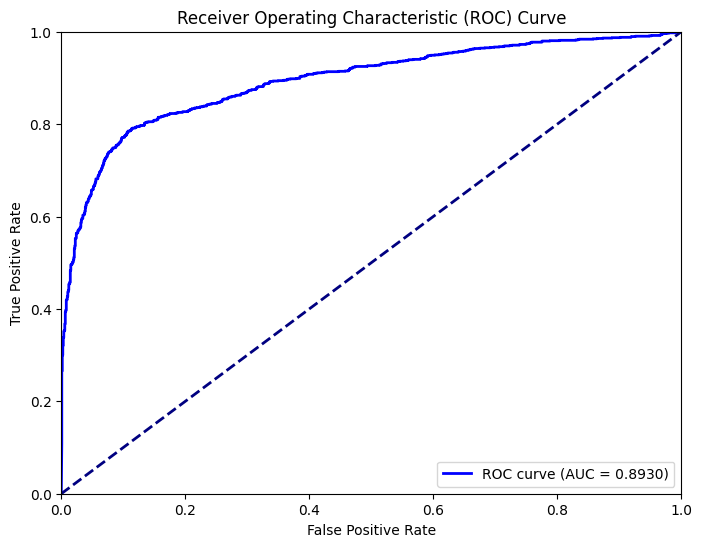

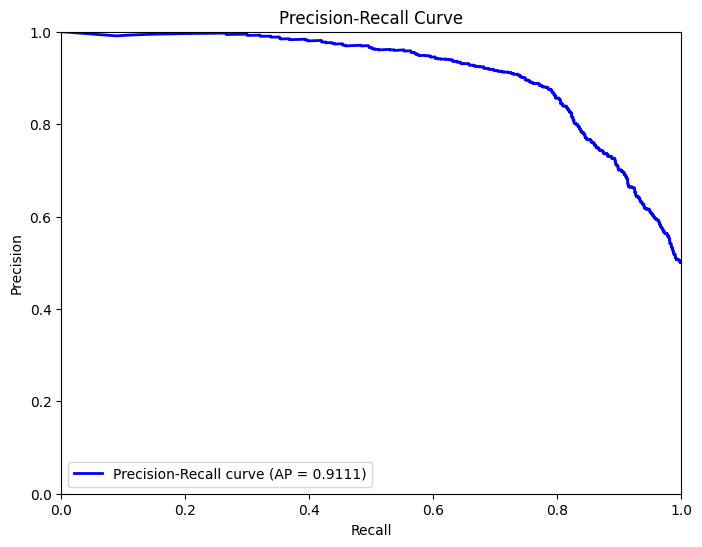

In [ ]:
#Model Testing
from sklearn.metrics import roc_auc_score,roc_curve
test_edge_label_index = test_data["drug", "HasIndication", "disorder"].edge_label_index
test_edge_label = test_data["drug", "HasIndication", "disorder"].edge_label
print(len(test_edge_label))
test_loader=MiniBatchesLoader(test_data,test_edge_label_index, test_edge_label, bs)
for i in test_loader:
  print(i)
test_loss, test_accuracy,test_AUCPR, test_AUC_ROC, fpr, tpr, precision, recall=Test(test_loader)

# Save values to a text file on Google Drive
results_path = '/content/drive/MyDrive/NedRex_HBKG_Results.txt'

with open(results_path, 'w') as file:
    file.write(f"Test Loss: {test_loss}\n")
    file.write(f"Test Accuracy: {test_accuracy}\n")
    file.write(f"Test AUCPR: {test_AUCPR}\n")
    file.write(f"Test AUC ROC: {test_AUC_ROC}\n")


#wandb.log({"test_loss":test_loss,"test_accuracy": test_accuracy,"test_AUCPR":test_AUCPR,"test_AUC_ROC":test_AUC_ROC},step=epoch)
print({"test_loss":test_loss,"test_accuracy": test_accuracy,"test_AUCPR":test_AUCPR,"test_AUC_ROC":test_AUC_ROC})
AUC_results_path = '/content/drive/MyDrive/NedRex_HBKG_AUC.txt'
AUPR_results_path = '/content/drive/MyDrive/NedRex_HBKG_AUPR.txt'
# Save values to individual text files
np.savetxt(AUC_results_path, np.column_stack((fpr, tpr)), header='FPR TPR', comments='', delimiter='\t')
np.savetxt(AUPR_results_path, np.column_stack((precision, recall)), header='Precision Recall', comments='', delimiter='\t')

# Create a figure and axis
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % test_AUC_ROC)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Create a figure and axis
plt.figure(figsize=(8, 6))
plt.title('Precision-Recall Curve')

# Plot the Precision-Recall curve
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.4f)' % test_AUCPR)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')

# Show the plot
plt.show()





In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# List of file paths
file_paths = ['/content/drive/MyDrive/Limited_HBKG_AUC.txt',
              '/content/drive/MyDrive/Limited_HBKG_With_NodeFeatures_AUC.txt',
              '/content/drive/MyDrive/NedRex_HBKG_AUC.txt',
              '/content/drive/MyDrive/NedRex_HBKG_With_NodeFeatures_AUC.txt',
              '/content/drive/MyDrive/NedRex_PFIN_AUC.txt']

# Initialize arrays to store TP and FP values from all files
all_tpr = []
all_fpr = []

# Initialize a list to store AUC values
all_auc = []

# Extract file names from paths for labeling
file_names = [os.path.splitext(os.path.basename(path))[0] for path in file_paths]

# Load data from each file and append to arrays
for file_path in file_paths:
    roc_data = np.loadtxt(file_path, comments='#', delimiter='\t', skiprows=1)
    all_fpr.append(roc_data[:, 0])
    all_tpr.append(roc_data[:, 1])

    # Calculate AUC and append to the list
    auc_value = auc(roc_data[:, 0], roc_data[:, 1])
    all_auc.append(auc_value)

# Create a figure and axis
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Plot the ROC curves from all files with corresponding labels
for i in range(len(file_paths)):
    fpr, tpr = all_fpr[i], all_tpr[i]
    plt.plot(fpr, tpr, lw=2, label=f'{file_names[i]}  = {all_auc[i]:.4f}')

# Diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()




In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# List of file paths
file_paths = ['/content/drive/MyDrive/NedRex_HBKG_With_NodeFeatures_AUPR.txt',
              '/content/drive/MyDrive/Limted_HBKG_AUPR.txt',
              '/content/drive/MyDrive/Limited_HBKG_With_NodeFeatures_AUPR.txt',
              '/content/drive/MyDrive/NedRex_HBKG_AUPR.txt',
              '/content/drive/MyDrive/NedRex_PFIN_AUPR.txt']

# Initialize arrays to store precision and recall values from all files
all_precision = []
all_recall = []

# Initialize a list to store AUC-PR values
all_auc_pr = []

# Extract file names from paths for labeling
file_names = [os.path.splitext(os.path.basename(path))[0] for path in file_paths]

# Load data from each file and append to arrays
for file_path in file_paths:
    pr_data = np.loadtxt(file_path, comments='#', delimiter='\t', skiprows=1)
    all_precision.append(pr_data[:, 0])
    all_recall.append(pr_data[:, 1])

    # Calculate AUC-PR and append to the list
    auc_value_pr = auc(pr_data[:, 1], pr_data[:, 0])
    all_auc_pr.append(auc_value_pr)

# Create a figure and axis
plt.figure(figsize=(8, 6))
plt.title('Precision-Recall Curve')

# Plot the Precision-Recall curves from all files with corresponding labels (including AUC-PR values)
for i in range(len(file_paths)):
    precision, recall = all_precision[i], all_recall[i]
    auc_pr_value = all_auc_pr[i]
    plt.plot(recall, precision, lw=2, label=f'{file_names[i]}  = {auc_pr_value:.4f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()




In [ ]:
def save_results_to_file(file_path, results):
    with open(file_path, 'w') as file:
        for key, value in results.items():
            file.write(f"{key}: {value}\n")

In [ ]:
data["drug", "HasIndication", "disorder"].edge_index

In [ ]:
test_data_label

In [ ]:
import pandas as pd

#Map Diseases IDs and Deugs IDs to Diseases Names and Drugs Names
df = pd.read_csv(disorder_path)
df2 = pd.read_csv(drug_path)
key_column = 'primaryDomainId:ID'
value_column = 'displayName:string'

Dis_dict = df[[key_column, value_column]].set_index(key_column).to_dict()[value_column]
Dru_dict2 = df2[[key_column, value_column]].set_index(key_column).to_dict()[value_column]
print(Dis_dict)
print(Dru_dict2)

In [ ]:
#Predict novel Drug-Disease links
num_disorders = len(disorder_mapping)
num_drugs = len(drug_mapping)

reverse_disorder_mapping = dict(zip(disorder_mapping.values(),disorder_mapping.keys()))
reverse_drug_mapping = dict(zip(drug_mapping.values(),drug_mapping.keys()))

results = []
with open('Prediction.txt', 'w') as file:


 for drug_index in range(0,num_drugs):

    row = torch.tensor([drug_index] * num_disorders)

    col = torch.arange(num_disorders)

    edge_label_index = torch.stack([row, col], dim=0)


    pred = model(test_data.x_dict, test_data.edge_index_dict,
                 edge_label_index)


    drug_id = reverse_drug_mapping[drug_index]

    mask = (pred>=1.0).nonzero(as_tuple=True)

    ten_predictions = [reverse_disorder_mapping[el] for el in  mask[0].tolist()[:50]]
    for i in ten_predictions:
     file.write(drug_id+"\t"+Dru_dict2[drug_id]+"\t"+i+"\t"+Dis_dict[i]+"\n")
     #results.append({'drug': Dru_dict2[drug_id], 'disorder': ten_predictions})

In [ ]:
#Predict novel Drug-Disease links
num_disorders = len(disorder_mapping)
num_drugs = len(drug_mapping)

reverse_disorder_mapping = dict(zip(disorder_mapping.values(),disorder_mapping.keys()))
reverse_drug_mapping = dict(zip(drug_mapping.values(),drug_mapping.keys()))

results = []
with open('Prediction.txt', 'w') as file:



    row = torch.tensor([16299] * num_drugs)

    col = torch.arange(num_drugs)

    edge_label_index = torch.stack([row, col], dim=0)


    pred = model(test_data.x_dict, test_data.edge_index_dict,
                 edge_label_index)


    disorder_id = reverse_disorder_mapping[16299]

    mask = (pred>=1.0).nonzero(as_tuple=True)

    ten_predictions = [reverse_drug_mapping[el] for el in  mask[0].tolist()[:50]]
    for i in ten_predictions:
     file.write(drug_id+"\t"+Dru_dict2[drug_id]+"\t"+i+"\t"+Dis_dict[i]+"\n")

In [ ]:
for k, value in reverse_disorder_mapping.items():
  if value=='mondo.0005098':
    print(k)
reverse_disorder_mapping[16299]

In [ ]:
#Training GAT Model
def TrainGAT(train_loader):
    total_Precision = total_auc_score=total_correct=total_loss = total_examples = 0
    preds = []
    ground_truths = []
    cumulative_correct = 0
    cumulative_total = 0
    model.train()
    for sampled_data in tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred=model(sampled_data.x_dict, sampled_data.edge_index_dict, sampled_data['drug', 'HasIndication', 'disorder'].edge_label_index)
        ground_truth = sampled_data["drug", "HasIndication", "disorder"].edge_label.to(float)
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        # Compute batch accuracy
        batch_correct = sum((pred > 0.75)==ground_truth)  # Direct comparison without axis
        batch_total = len(ground_truth)

        preds.append(pred)
        ground_truths.append(ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()

        total_examples += pred.numel()
        # Store values for batch-wise averaging
        cumulative_correct += float(batch_correct)

    train_loss= total_loss / total_examples
    # Calculate overall accuracy
    train_accuracy = float(cumulative_correct) / total_examples
    Fpred = torch.cat(preds, dim=0).cpu().detach().numpy()
    Fground_truth = torch.cat(ground_truths, dim=0).cpu().detach().numpy()
    aucroc = roc_auc_score(Fground_truth, Fpred)
    # Assuming you have precision and recall values obtained from your predictions and true labels
    precision, recall, thresholds = precision_recall_curve(Fground_truth, Fpred)

   # Calculate AUCPR
    aucpr = auc(recall, precision)
    return train_loss, train_accuracy, aucpr, aucroc

In [ ]:
#Validation and testing GAT
def TestGAT(data_loader):
  batch_auc_roc_score=total_correct=total_val_loss = total_examples= 0
  preds = []
  ground_truths = []
  cumulative_correct = 0
  cumulative_total = 0
  for sampled_data in tqdm(data_loader):
       with torch.no_grad():
         sampled_data.to(device)
         pred=model(sampled_data.x_dict, sampled_data.edge_index_dict, sampled_data["drug", "HasIndication", "disorder"].edge_label_index)
         ground_truth = sampled_data["drug", "HasIndication", "disorder"].edge_label.to(float)
         preds.append(pred)
         ground_truths.append(ground_truth)
         loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
         total_val_loss += float(loss) * pred.numel()
         total_examples += pred.numel()
          # Compute batch accuracy

         batch_correct = sum((pred > 0.75) == ground_truth)


          # Store values for batch-wise averaging
         cumulative_correct += float(batch_correct)

       # Compute average validation loss

  val_loss= total_val_loss / total_examples
   # Calculate overall accuracy
  val_accuracy = cumulative_correct / total_examples
  Fpred = torch.cat(preds, dim=0).cpu().detach().numpy()
  Fground_truth = torch.cat(ground_truths, dim=0).cpu().detach().numpy()

  aucroc = roc_auc_score(Fground_truth, Fpred)
    # Assuming you have precision and recall values obtained from your predictions and true labels
  precision, recall, thresholds = precision_recall_curve(Fground_truth, Fpred)

   # Calculate AUCPR
  aucpr = auc(recall, precision)
  return val_loss, val_accuracy, aucpr, aucroc

In [ ]:
#Validation using External database
def TestGAT(data_loader):
  batch_auc_roc_score=total_correct=total_val_loss = total_examples= 0
  preds = []
  ground_truths = []
  cumulative_correct = 0
  cumulative_total = 0
  for sampled_data in tqdm(data_loader):
       with torch.no_grad():
         sampled_data.to(device)
         pred=model(sampled_data.x_dict, sampled_data.edge_index_dict, sampled_data["drug", "HasIndication", "disorder"].edge_label_index)
         ground_truth = sampled_data["drug", "HasIndication", "disorder"].edge_label.to(float)
         preds.append(pred)
         ground_truths.append(ground_truth)
         loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
         total_val_loss += float(loss) * pred.numel()
         total_examples += pred.numel()
          # Compute batch accuracy

         batch_correct = sum((pred > 0.75) == ground_truth)


          # Store values for batch-wise averaging
         cumulative_correct += float(batch_correct)

       # Compute average validation loss

  val_loss= total_val_loss / total_examples
   # Calculate overall accuracy
  val_accuracy = cumulative_correct / total_examples
  Fpred = torch.cat(preds, dim=0).cpu().detach().numpy()
  Fground_truth = torch.cat(ground_truths, dim=0).cpu().detach().numpy()

  aucroc = roc_auc_score(Fground_truth, Fpred)
    # Assuming you have precision and recall values obtained from your predictions and true labels
  precision, recall, thresholds = precision_recall_curve(Fground_truth, Fpred)

   # Calculate AUCPR
  aucpr = auc(recall, precision)
  return val_loss, val_accuracy, aucpr, aucroc